In [128]:
from dolfin import *
from IPython.display import HTML
import matplotlib.pyplot as plt
import mshr as mh
import time
from math import floor
%matplotlib inline

La ecuación que trabajaremos será la ecuación del calor en medio isotrópico no homogéneo

$$u_t - \kappa(x)A(x)\nabla u = f_e(x)$$

Donde

* $u(x,t)$ es la temperatura

* $f_e(x)$ representa una fuente o fuentes de calor (estufas).

* $\kappa(x) = \dfrac{1}{\rho c_e}$ es la inversa (multiplicativa) del calor específico, multiplicado por la densidad, del medio en $x$. Se asumirá constante por pedazos (los medios que trabajaremos serán aire y paredes principalmente).

* $A(x)$ es la conductividad térmica del medio en $x$. Al asumir un medio isotrópico (cuya conductividad no depende de la dirección) es una matriz diagonal. También la asumimos constante por pedazos (de no serlo, ese término sería $\kappa(x) \sum_{i,j} \partial_{x_i} (A(x)\partial_{x_j}u)$)

Usaremos diferentes condiciones de borde. Podemos asumir, por ejemplo, condiciones de borde de tipo Dirichlet (temperatura exterior constante), condiciones de borde de tipo Neumann (para modelar el hecho de que hay temperatura que sale al exterior), o bien una condición mixta.


En primer lugar, se trabajará el problema 2-dimensional. Posteriormente se extenderá al caso 3-dimensional.

In [129]:
#### Caso 2D ####
'''
Los parámetros a definir serán:
la discretización temporal (número de pasos),
la temperatura exterior,
la temperatura y posición de la estufa,
las áreas que son paredes,
el calor específico y conductividad térmica de cada medio (aire, pared)
'''
#Parámetros
T = 1800 # Tiempo final (segundos)
número_pasos = 200
temperatura_exterior = 10.
temperatura_estufa = 600.
x_estufa = 2/7 #posición de la estufa
y_estufa = 5/7
#Booleano que, en C++, evalúa que un punto esté dentro de alguna pared (después probablemente lo haré con clases) 
en_paredes = "(x[0]<=1/7 || x[0]>= 6/7 || x[1]<=1/7 || x[1]>= 6/7)"
#Calores específicos, densidades y conductividades térmicas de ambos medios (pared y aire)
#(Los asumiremos constantes, en realidad cambian con la temperatura y presión: esto será importante en el caso 3D)
cal_esp_p = 0.88
rho_p = 2300 #asumimos pared de concreto
cond_p = 1.63

cal_esp_a = 1.01
rho_a = 1.24
cond_a = 0.02

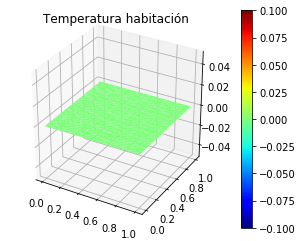

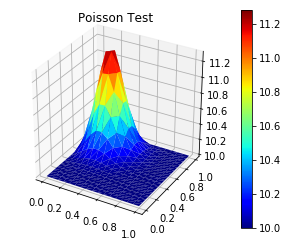

Tiempo: 9.00, solución guardada con norma L2 10.148841


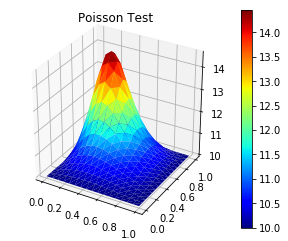

Tiempo: 189.00, solución guardada con norma L2 11.064245


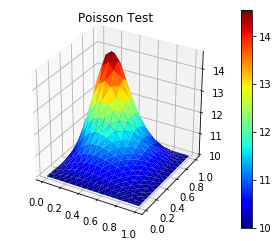

Tiempo: 369.00, solución guardada con norma L2 11.122995


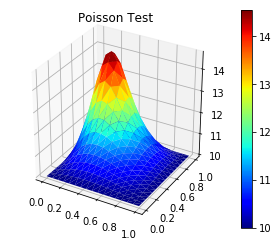

Tiempo: 549.00, solución guardada con norma L2 11.126949


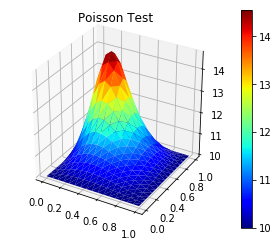

Tiempo: 729.00, solución guardada con norma L2 11.127215


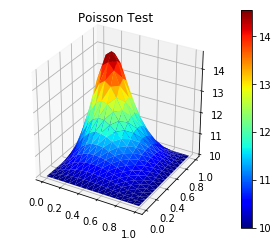

Tiempo: 909.00, solución guardada con norma L2 11.127233


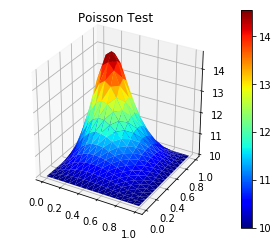

Tiempo: 1089.00, solución guardada con norma L2 11.127234


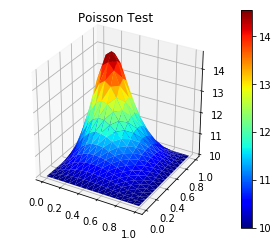

Tiempo: 1269.00, solución guardada con norma L2 11.127234


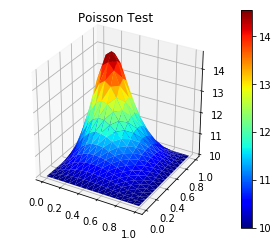

Tiempo: 1449.00, solución guardada con norma L2 11.127234


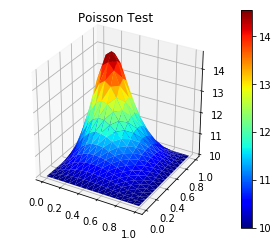

Tiempo: 1629.00, solución guardada con norma L2 11.127234
Iteración terminada


In [131]:
#Esto no se toca, salvo para debuggear

# Paso de tiempo
Δt = T / número_pasos

# Crear malla y si es necesario, refinar cerca de la estufa
malla = UnitSquareMesh(16,16)
"""malla = UnitSquareMesh(16,16)
subdom = MeshFunction("bool", malla, 2)
subdom.set_all(False)
circulito = 'pow(x[0] - x_0, 2) + pow(x[1] - x_1, 2) <= pow(r, 2)'
subdomain = CompiledSubDomain(circulito, x_0 = x_estufa,x_1 = y_estufa,r = 0.1)
subdomain.mark(subdom, True)
malla = refine(malla, subdom)"""
# Espacio de funciones a considerar
V = FunctionSpace(malla,'Lagrange', 1)

##Funciones
#algunas variables auxiliares
eps = 0.02
en_aire = "!"+en_paredes  #el aire es el espacio que queda

#Función de la fuente
f = Expression("t_e*exp(-(pow(x[0] - x_e, 2) + pow(x[1] - y_e, 2))/reg)", degree = 1,
               x_e = x_estufa, y_e = y_estufa,
               t_e = temperatura_estufa, reg = eps)
#Función de conductividad térmica
K = Expression("k_pared*"+en_paredes+" + k_aire*"+en_aire, degree=1,
              k_pared = cond_p, k_aire  = cond_a)
#Función de calor específico (junto con la densidad)
ρC = Expression("d_pared*C_pared*"+en_paredes+" + d_aire*C_aire*"+en_aire, degree = 1,
                d_pared = rho_p, C_pared = cal_esp_p,
                d_aire  = rho_a,  C_aire = cal_esp_a)
# Condiciones de borde
#Borde Dirichlet
cpp_borde = "(x[0] < DOLFIN_EPS || x[0] > 1. - DOLFIN_EPS || x[1] < DOLFIN_EPS || x[1] > 1. - DOLFIN_EPS ) && on_boundary"
bc = DirichletBC(V, Constant(temperatura_exterior), cpp_borde)

#Borde Neumann (consideraremos que no varía en los bordes: más adelante, variará según la temperatura de afuera)
g = Expression("0.", degree = 1)

#Funciones para la formulación variacional
u, v = TrialFunction(V), TestFunction(V)
u_n = Function(V)

##Formulación variacional y sistema lineal
F = u*v*dx + Δt*inner(grad(u), grad(v))*(K/ρC)*dx - (u_n + Δt*f/ρC)*v*dx - Δt*g*v*ds
a, L = lhs(F), rhs(F)

# Preparación para guardar la solución
archivo_sol = File('Resultados/calor.pvd')
sols = []

# Iteración principal
u = Function(V)
u_n.assign(Expression(str(temperatura_exterior), degree = 1))
fig = plt.figure()
p = plot(u, title="Temperatura habitación", mode="warp")
fig.colorbar(p)
plt.show()
t = 0
for n in range(número_pasos):
    # Update-time
    t += Δt
    # Solve linear system
    solve(a == L, u, bc)
    
    # Save results
    archivo_sol << (u, t)
    
    if n % floor(número_pasos/10) == 0:
        fig = plt.figure()
        p = plot(u, title="Poisson Test", mode="warp")
        fig.colorbar(p)
        plt.show()
        print("Tiempo: {:.2f}, solución guardada con norma L2 {:4f}".format(t,norm(u, "L2")))
    # Update solution at time n and save to list for plotting
    u_n.assign(u)
    sols.append(u.copy(deepcopy=True))

print("Iteración terminada")